In [109]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [162]:
def box_iou_batch(
	boxes_a: np.ndarray, boxes_b: np.ndarray
) -> np.ndarray:

    def box_area(box):
        return (box[2] - box[0]) * (box[3] - box[1])

    area_a = box_area(boxes_a.T)
    area_b = box_area(boxes_b.T)

    top_left = np.maximum(boxes_a[:, None, :2], boxes_b[:, :2])
    bottom_right = np.minimum(boxes_a[:, None, 2:], boxes_b[:, 2:])

    area_inter = np.prod(
    	np.clip(bottom_right - top_left, a_min=0, a_max=None), 2)
        
    return area_inter / (area_a[:, None] + area_b - area_inter)

def non_max_suppression(
   predictions: np.ndarray, iou_threshold: float = 0.5
) -> np.ndarray:
    rows, columns = predictions.shape

    sort_index = np.flip(predictions[:, 4].argsort())
    predictions = predictions[sort_index]

    boxes = predictions[:, :4]
    categories = predictions[:, 5]
    ious = box_iou_batch(boxes, boxes)
    ious = ious - np.eye(rows)
    # print(ious)

    keep = np.ones(rows, dtype=bool)

    for index, (iou, category) in enumerate(zip(ious, categories)):
        if not keep[index]:
            continue

        condition = (iou > iou_threshold) & (categories == category)
        keep = keep & ~condition

    return keep[sort_index.argsort()]

def xywh2xyxy(x):
    # Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(
        im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )  # add border
    return im, r, (dw, dh)

In [110]:
model = tf.saved_model.load("yolov5m_saved_model/1")

In [176]:
rasm = cv2.imread("1.png")
rasm.shape

(600, 1600, 3)

In [177]:
a, ratio, dwdh = letterbox(rasm, auto=False)
a = np.expand_dims(a, 0)
a = np.ascontiguousarray(a)
a = a.astype(np.float32)
a /= 255

In [178]:
pred = np.array(model(a)[0])[0]

In [179]:
filt = np.array(list(filter(lambda x: x[4] >= 0.7, pred)))

In [180]:
filt[:, :4] = 640 * filt[:, :4]

In [181]:
boxes = filt[:, :5]

In [182]:
boxes = xywh2xyxy(np.concatenate((boxes, np.expand_dims(np.argmax(filt[:, 5:], axis=1), 1)), axis=1))

In [183]:
indices = non_max_suppression(boxes, 0.3)

In [184]:
boxes[indices].shape

(4, 6)

In [185]:
boxes[indices]

array([[252.46686172, 260.23100662, 312.61852646, 298.61616135,
          0.87535441,  63.        ],
       [151.76484871, 200.07246017, 207.11027336, 275.39876175,
          0.73131484,  58.        ],
       [  0.64497757, 248.62695312,  99.84375381, 332.39074707,
          0.90239948,  57.        ],
       [324.45193481, 225.37033081, 438.38778687, 434.81283569,
          0.91957825,  56.        ]])

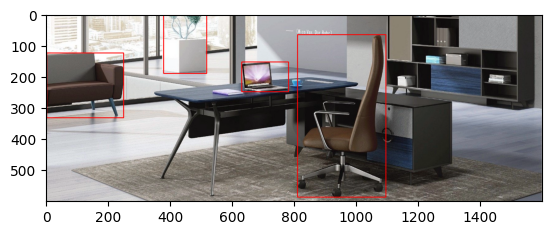

In [186]:
color = (255, 0, 0)
for i in boxes[indices]:
    bbox = i[:4].copy()
    bbox[0] -= dwdh[0]
    bbox[1] -= dwdh[1]
    bbox[2] -= dwdh[0]
    bbox[3] -= dwdh[1]
    bbox /= ratio
    bbox = bbox.round().astype(np.int32).tolist()
    cv2.rectangle(rasm, tuple(bbox[:2]), tuple(bbox[2:]), color, 2)
plt.imshow(rasm)